---

# DS400: Assignment V (Python)

##### Sahra Pfeifer (Student ID: 4184977)
##### February, 01.2023

---

### Setting up a new GitHub repository


<div class="alert alert-block alert-info">
    
(1) Register on github.com in case you have not done this already.
</div>

In [1]:
# Load relevant packages
import numpy as np
import pandas as pd
import requests as r
import time  

---
<div class="alert alert-block alert-info">
    
(2) Initialize a new public repository for this assignment on GitHub.
</div>

---
<div class="alert alert-block alert-info">
    
(3) For the following exercises of this assignment, follow the standard Git workflow (i.e., pull the latest
version of the project to your local computer, then stage, commit, and push all the modifications that you
make throughout the project). Every logical programming step should be well documented on GitHub
with a meaningful commit message, so that other people (e.g., your course instructor) can follow and
understand the development history. You can do this either using Shell commands or a Git GUI of your
choice.
</div>

---
<div class="alert alert-block alert-info">
    
(4) In the HTML file that you submit, include the hyperlink to the project repository (e.g., https://github.
com/yourUserName/yourProjectName)
</div>

[Python repository]https://github.com/sahrapfeifer/Assignment_V_Py.git

---

### Getting to know the API


<div class="alert alert-block alert-info">
    
(5) Visit the documentation website for the API provided by ticketmaster.com (see here). Familiarize yourself
with the features and functionalities of the Ticketmaster Discovery API. Have a particular look at
rate limits.
</div>

All API keys are issued with a default quota of 5000 API calls per day and rate limitation of 5 requests per second. 

---
<div class="alert alert-block alert-info">
    
(6) Whithin the scope of this assignment, you do not have to request your own API key. Instead retrieve
a valid key from the API Explorer. This API key enables you to perform the GET requests needed
throughout this assignment. Even though this API key is not secret per se (it is publicly visible on the
API Explorer website), please comply to the common secrecy practices discussed in the lecture and the
tutorial: Treat the API key as a secret token. Your API key should neither appear in the code that you
are submitting nor in your public GitHub repository.
</div>

key is stored in a separate script ("API_Explorer_Key.Py")

In [2]:
# access the key from main script using:
with open("API_Explorer_Key.py") as script:
  exec(script.readline())

---

### Interacting with the API - the basics


<div class="alert alert-block alert-info">
    
(7) Perform a first GET request, that searches for event venues in Germany (countryCode = "DE"). Extract
the content from the response object and inspect the resulting list. Describe what you can see.      
</div>

In [3]:
import requests

response = requests.get("https://app.ticketmaster.com/discovery/v2/venues/?", 
                        params = {"apikey": TM_expl_key, "countryCode":"DE", "locale":"*"}).json()


From the GET request we get a response. The response object contains three lists: _links, _embedded and pages. In pages we find the total count of all venues in Germany and the number of pages. One page contains 20 venues. _embedded is a list of lists of lists. Each list in _embedded marks one page and contains lists of data of 20 venues, except for the last page list which contains only 7. Each venues list contains data for a venue, f.e. name of the event, city, coordinates and so on.

---
<div class="alert alert-block alert-info">
    
(8) Extract the name, the city, the postalCode and address, as well as the url and the longitude
and latitude of the venues to a data frame. This data frame should have the following structure:
</div>

In [4]:
## Rows: 20
## Columns: 7
## $ name <chr> "Gruenspan", "Huxleys Neue Welt", "Kleine Olympiahalle", "Z~
## $ city <chr> "Hamburg", "Berlin", "Munich", "Emmelshausen", "Mülheim", "~
## $ postalCode <dbl> 22767, 10967, 80809, 56281, 45479, 76646, 68766, 44263, 542~
## $ address <chr> "Grosse Freiheit 58", "Hasenheide 107 – 113", "Spiridon-Lou~
## $ url <chr> "http://www.ticketmaster.de/venue/287155", "http://www.tick~
## $ longitude <dbl> 9.958075, 13.421380, 11.550920, 7.556560, 6.874710, 8.59908~
## $ latitude <dbl> 53.55188, 52.48639, 48.17543, 50.15544, 51.42778, 49.12692,~    


In [5]:
# use pandas implemented function pd.json_normalize()
venues_op = pd.json_normalize(response["_embedded"], record_path=["venues"])

# Select desired columns:
venues_op = venues_op[["name","url","postalCode","city.name","address.line1","location.longitude","location.latitude"]]

# change names:
venues_op = venues_op.rename(columns={"city.name":"name", "address.line1":"address",
  "location.longitude":"longitude","location.latitude":"latitude"})

# convert to numeric:
colsnum = ["postalCode","longitude","latitude"]

venues_op[colsnum] = venues_op[colsnum].apply(pd.to_numeric, errors="coerce")

# print first 10 results:
print(venues_op.head(10))
print(np.shape(venues_op))

                       name  \
0        Grosse Freiheit 36   
1                 Gruenspan   
2         Huxleys Neue Welt   
3           Zentrum am Park   
4  Stadthalle (Theatersaal)   
5             Schlossgarten   
6                Stadthalle   
7                       FZW   
8               Arena Trier   
9             Eissporthalle   

                                                 url  postalCode  \
0            http://www.ticketmaster.de/venue/287636       22767   
1            http://www.ticketmaster.de/venue/287155       22767   
2            http://www.ticketmaster.de/venue/286842       10967   
3  https://www.ticketmaster.de/venue/zentrum-am-p...       56281   
4  https://www.ticketmaster.de/venue/stadthalle-t...       45479   
5  https://www.ticketmaster.de/venue/schlossgarte...       76646   
6  https://www.ticketmaster.de/venue/stadthalle-h...       68766   
7  https://www.ticketmaster.de/venue/fzw-dortmund...       44263   
8  https://www.ticketmaster.de/venue/arena-tri

---

### Interacting with the API - advanced


<div class="alert alert-block alert-info">
    
(9) Have a closer look at the list element named page. Did your GET request from exercise (7) return all
event locations in Germany? Obviously not - there are of course much more venues in Germany than
those contained in this list. Your GET request only yielded the first results page containing the first
20 out of several thousands of venues. Check the API documentation under the section Venue Search.
How can you request the venues from the remaining results pages? Iterate over the results pages and
perform GET requests for all venues in Germany. After each iteration, extract the seven variables name,
city, postalCode, address, url, longitude, and latitude. Join the information in one large
data frame. Print the first 10 rows and the shape of the resulting data frame. The resulting data frame
should look something like this (note that the exact number of search results may have changed since
this document has been last modified):
</div>

In [6]:
## Rows: 12,671
## Columns: 7
## $ name <chr> "Gruenspan", "Huxleys Neue Welt", "Kleine Olympiahalle", "Z~
## $ city <chr> "Hamburg", "Berlin", "Munich", "Emmelshausen", "Mülheim", "~
## $ postalCode <dbl> 22767, 10967, 80809, 56281, 45479, 76646, 68766, 44263, 542~
## $ address <chr> "Grosse Freiheit 58", "Hasenheide 107 – 113", "Spiridon-Lou~
## $ url <chr> "http://www.ticketmaster.de/venue/287155", "http://www.tick~
## $ longitude <dbl> 9.958075, 13.421380, 11.550920, 7.556560, 6.874710, 8.59908~
## $ latitude <dbl> 53.55188, 52.48639, 48.17543, 50.15544, 51.42778, 49.12692,~

In [7]:
# load relevant package to stop time after each iteration:
import time

# store number of totalElements:
n = int(response["page"]["totalElements"])
n

# create object with desired columns:
cols = ["name","url","postalCode","city.name","address.line1","location.longitude","location.latitude"]

# create an empty list to contain all results
list_all = [None] * ((n // 20) + (n % 20 > 0))
list_none = [None] * ((n // 20) + (n % 20 > 0))
# cols = ["name","url","postalCode","city.name","address.line1","location.longitude","location.latitude"]

# loop over all pages and store the result in list
for page in (np.arange((n // 20) + (n % 20 > 0))+1):
      try:
      # enforce a rate limit
        time.sleep(.2)
        # call the API and get the respective page
        res_venues = requests.get("https://app.ticketmaster.com/discovery/v2/venues/?", 
                          params = {"apikey": TM_expl_key, "countryCode":"DE","page": page, "locale":"*" }).json()
        # store search items in list:
        list_all[page -1] = res_venues["_embedded"]

        list_none = [i for i in list_all if i is not None]
    
        venues_all = pd.json_normalize(list_none, record_path=["venues"])
        # extract desired columns
        venues_all = venues_all[cols]
    
      except KeyError:
             continue


In [8]:
# change names:
venues_all = venues_all.rename(columns={"city.name":"city", "address.line1":"address",
  "location.longitude":"longitude","location.latitude":"latitude"})

# convert to numeric:
colsnum = ["postalCode","longitude","latitude"]

venues_all[colsnum] = venues_all[colsnum].apply(pd.to_numeric, errors="coerce")


# print first 10 observations:
print(venues_all.head(10))
print(np.shape(venues_all))

                          name  \
0     Mies-van-der-Rohe-Schule   
1  Willingen (Upland) Open Air   
2  Häkken (Klubhaus St. Pauli)   
3                Bahnhof Pauli   
4                   Club Volta   
5         edel-optics.de Arena   
6                      Kurhaus   
7                     Junkyard   
8        Kulturquartier Proton   
9        Aula am Berliner Ring   

                                                 url  postalCode  \
0  https://www.ticketmaster.de/venue/mies-van-der...     52068.0   
1  https://www.ticketmaster.de/venue/willingen-up...     34508.0   
2  https://www.ticketmaster.de/venue/hakken-klubh...     20359.0   
3  https://www.ticketmaster.de/venue/bahnhof-paul...     20539.0   
4  https://www.ticketmaster.de/venue/club-volta-k...     51063.0   
5  https://www.ticketmaster.de/venue/edel-opticsd...     21109.0   
6  https://www.ticketmaster.de/venue/kurhaus-bern...      6406.0   
7  https://www.ticketmaster.de/venue/junkyard-dor...     44145.0   
8  https://ww

---

###  Visualizing the extracted data


<div class="alert alert-block alert-info">
    
(10) Below, you can find code that produces a map of Germany. Add points to the map indicating the
locations of the event venues across Germany.
</div>

<AxesSubplot: xlabel='longitude', ylabel='latitude'>

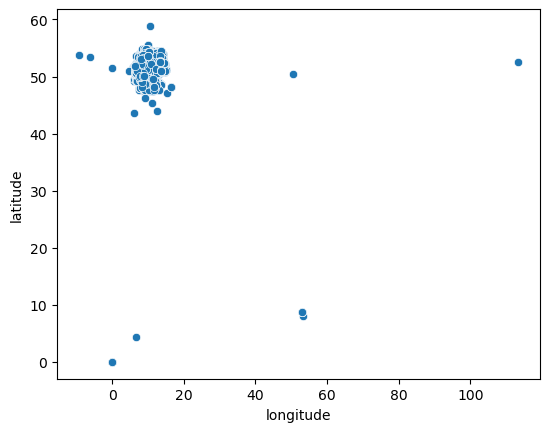

In [9]:
# Python
import geopandas as gpd
import seaborn as sn

# get a base map of Germany
map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
map = map[map.name == "Germany"]
# plot the map
map.plot()
sn.scatterplot(data = venues_all, x = "longitude", y = "latitude")

<div class="alert alert-block alert-info">
    
(11) You will find that some coordinates lie way beyond the German borders and can be assumed to be faulty.
Set coordinate values to NA where the value of longitude is outside the range (5.866, 15.042) or
where the value of latitude is outside the range (47.270, 55.059) (these coordinate ranges have
been derived from the extreme points of Germany as listed on Wikipedia (see here). For extreme points
of other countries, see here).
</div>

<AxesSubplot: xlabel='longitude', ylabel='latitude'>

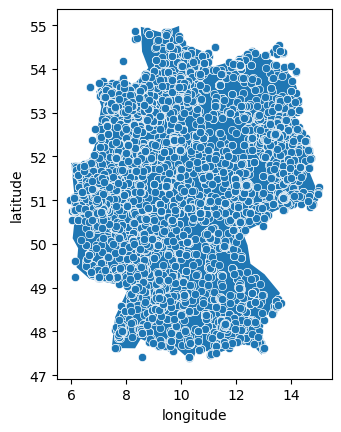

In [10]:
# Insert NaN's outside DE range:
# use "where" and "between" statement (similar like in R)

# for longitude:
venues_all.longitude = venues_all.longitude.where(venues_all.longitude.between(5.866,15.042))  

# for latitude:
venues_all.latitude = venues_all.latitude.where(venues_all.latitude.between(47.270,55.059))  


# Python
map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
map = map[map.name == "Germany"]
# plot the map
map.plot()
sn.scatterplot(data = venues_all, x = "longitude", y = "latitude")

---

###  Event locations in other countries


<div class="alert alert-block alert-info">
    
(12) Repeat exercises (9)–(11) for another European country of your choice. (Hint: Clean code pays off! If
you have coded the exercises efficiently, only very few adaptions need to be made.)
</div>

In [11]:
# content response from Spain:
response_ES = requests.get("https://app.ticketmaster.com/discovery/v2/venues/?", 
                           params = {"apikey": TM_expl_key, "countryCode":"ES", "locale":"*"}).json()



In [12]:
########
# 9:
########
# store number of totalElements:
n_ES = int(response_ES["page"]["totalElements"])
n_ES

# create object with desired columns:
cols = ["name","url","postalCode","city.name","address.line1","location.longitude","location.latitude"]

# colsnum (see above): columns which shall be numeric

# create an empty list to contain all results
list_ES = [None] * ((n_ES // 20) + (n_ES % 20 > 0))
list_noneES = [None] * ((n_ES // 20) + (n_ES % 20 > 0))
# cols = ["name","url","postalCode","city.name","address.line1","location.longitude","location.latitude"]

# loop over all pages and store the result in list
for page in (np.arange((n_ES // 20) + (n_ES % 20 > 0))+1):
        try:
          # enforce a rate limit
            time.sleep(.2)
            # call the API and get the respective page
            res_venues = requests.get("https://app.ticketmaster.com/discovery/v2/venues/?", 
                          params = {"apikey": TM_expl_key, "countryCode":"ES","page": page, "locale":"*" }).json()
            # store search items in list:
            list_ES[page -1] = res_venues["_embedded"]

            list_noneES = [i for i in list_ES if i is not None]
            #for x in venues_list2:
            venues_ES = pd.json_normalize(list_noneES, record_path=["venues"])

            venues_ES = venues_ES[cols]

        except KeyError:
              continue
       



In [13]:
# change names:
venues_ES = venues_ES.rename(columns={"city.name":"city", "address.line1":"address",
  "location.longitude":"longitude","location.latitude":"latitude"})

# convert to numeric:
colsnum = ["postalCode","longitude","latitude"]

venues_ES[colsnum] = venues_ES[colsnum].apply(pd.to_numeric, errors="coerce")

# print first 10 results
print(venues_ES.head(10))

                               name  \
0                   Parc de Can Zam   
1                     Monte do Gozo   
2      Antiga Fàbrica Estrella Damm   
3                        Sala Shoko   
4   Warner Music Station Prínc. Pío   
5     Estadi Olímpic Lluis Companys   
6                            La Nau   
7  Palacio Municipal - IFEMA MADRID   
8         Recinto Multiusos de Onda   
9                         La Marina   

                                                 url  postalCode  \
0  https://www.ticketmaster.es/venue/parc-de-can-...      8924.0   
1  https://www.ticketmaster.es/venue/monte-do-goz...     15820.0   
2  https://www.ticketmaster.es/venue/antiga-fabri...      8025.0   
3  https://www.ticketmaster.es/venue/sala-shoko-m...     28005.0   
4  https://www.ticketmaster.es/venue/warner-music...     28008.0   
5  https://www.ticketmaster.es/venue/estadi-olimp...      8038.0   
6  https://www.ticketmaster.es/venue/la-nau-barce...      8005.0   
7  https://www.ticketmaste

<AxesSubplot: xlabel='longitude', ylabel='latitude'>

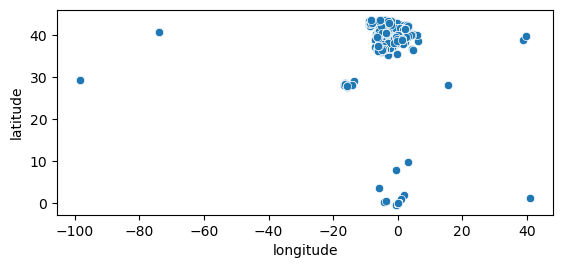

In [14]:
########
# 10:
########
# get a base map of Germany
map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
map = map[map.name == "Spain"]
# plot the map
map.plot()
sn.scatterplot(data = venues_ES, x = "longitude", y = "latitude")


<AxesSubplot: xlabel='longitude', ylabel='latitude'>

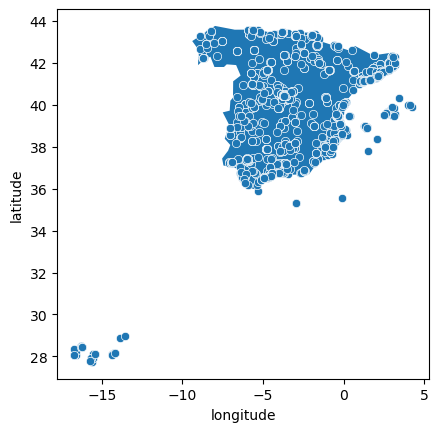

In [15]:
########
# 11:
########
# Insert NaN's outside DE range:
# use "where" and "between" statement (similar like in R)

# for longitude:
venues_ES.longitude = venues_ES.longitude.where(venues_ES.longitude.between(-17.934,4.289))  

# for latitude:
venues_ES.latitude = venues_ES.latitude.where(venues_ES.latitude.between(27.633, 43.738))  


# Python
map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
map = map[map.name == "Spain"]
# plot the map
map.plot()
sn.scatterplot(data = venues_ES, x = "longitude", y = "latitude")